In [4]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import heapq as hq

In [5]:
def completeGraph(nVertices):
    # Initialize the graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(nVertices))

    # List all possible edges
    edges = list(nx.non_edges(G))
    random.shuffle(edges)
    while not nx.is_connected(G):
        x, y = edges.pop()
        G.add_edge(x, y)

    return G

In [6]:
def drawGraph(G):
    plt.figure(figsize = (12,8), dpi = 50)
    nx.draw_networkx(G,
                     with_labels = True,
                     style = "solid",
                     node_size = 700,
                     node_color = "orange",
                     font_size = 14,
                     font_color = "black",
                     font_weight = "bold")
    plt.show()

/home/joseb/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


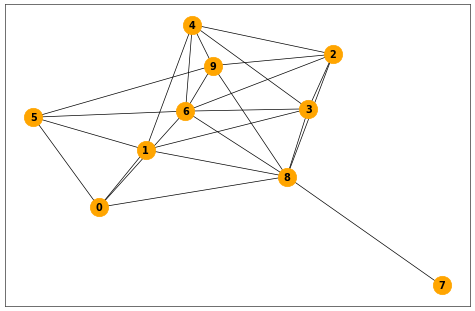

In [7]:
G = completeGraph(10)
drawGraph(G)

In [8]:
class FlowUpdatingBroad:
    def __init__(self, neighbors, inputValue, timeout):
        self.timeout = timeout
        self.messages = []
        self.neighbors = neighbors
        self.f = {}
        self.e = {}
        for n in neighbors:
            self.f[n] = 0
            self.e[n] = 0
        self.v = inputValue

    def gen_message(self):
        messages = [("TIMEOUT", self.timeout, True)]
        for n in self.neighbors:
            msg = (self.f[n], self.e[n])
            messages.append(("FLOW", (n, msg)))
        return messages

    def calculateEstimate(self):
        sumF = 0
        sumE = 0
        for n in self.neighbors:
            sumF += self.f[n]
            sumE += self.e[n]
        return (self.v - sumF + sumE) / (len(self.neighbors) + 1)

    def state_transition(self):
        for m in self.messages:
            src = m[0]
            (f, e) = m[1]
            self.f[src] = -f
            self.e[src] = e
            
        self.messages = []

        newE = self.calculateEstimate()
        
        stop = True
        for n in self.neighbors:
            if abs(round(newE, 3) - round(self.e[self.k], 3)) > 0.001:
                stop = False
            
            self.f[n] += newE - self.e[n]
            self.e[n] = newE
            
        return stop


    def handle(self, src, msg):
        if msg == "INITIAL":
            return self.gen_message()
        else:
            if msg[0] == "FLOW":
                self.messages.append((src, msg[1]))
            else: # timeout message, end of round
                if not self.state_transition():
                    return self.gen_message()
        return []

In [9]:
class FlowUpdatingUni:
    def __init__(self, neighbors, inputValue, timeout):
        self.timeout = timeout
        self.messages = []
        self.neighbors = neighbors
        self.f = {}
        self.e = {}
        self.k = self.chooseNeighbor()
        for n in neighbors:
            self.f[n] = 0
            self.e[n] = 0
        self.v = inputValue
        
    def chooseNeighbor(self):
        return random.choice(list(self.neighbors))

    def gen_message(self):
        messages = [("TIMEOUT", self.timeout, True)]
        msg = (self.f[self.k], self.e[self.k])
        messages.append(("FLOW", (self.k, msg)))
        return messages

    def calculateEstimate(self):
        sumF = 0
        sumE = 0
        for n in self.neighbors:
            sumF += self.f[n]
            sumE += self.e[n]
        return (self.v - sumF + sumE) / (len(self.neighbors) + 1)

    def state_transition(self):
        for m in self.messages:
            src = m[0]
            (f, e) = m[1]
            self.f[src] = -f
            self.e[src] = e
            
        self.messages = []

        newE = self.calculateEstimate()
        print(round(newE, 2), round(self.e[self.k], 2))
        
        stop = False
        if abs(round(newE, 2) - round(self.e[self.k], 2)) <= 0.05:
            stop = True
            
        self.k = self.chooseNeighbor()
        
        self.f[self.k] += newE - self.e[self.k]
        self.e[self.k] = newE
        
        return stop

    def handle(self, src, msg):
        if msg == "INITIAL":
            return self.gen_message()
        else:
            if msg[0] == "FLOW":
                self.messages.append((src, msg[1]))
            else: # timeout message, end of round
                if not self.state_transition():
                    return self.gen_message()
                else:
                    return [("TIMEOUT", self.timeout, True)]
        return []

In [10]:
class Simulator:
    def __init__(self, nodes, distances, faultProbability, viewChange, timeout):
        self.nodes = nodes
        self.distances = distances
        self.currentTime = 0
        self.pending = [] # [(delay, (src, dest, msg))]
        self.faultProbability = faultProbability
        self.viewChange = viewChange
        self.timeout = timeout

    def start(self):
        for n in self.nodes:
            event = (0, (None, n, "INITIAL"))
            hq.heappush(self.pending, event)

        # Add first view change
        if self.viewChange != -1:
            hq.heappush(self.pending, (self.viewChange, (float("+infinity"), None, "VIEWCHANGE")))

        return self.runLoop()

    def runLoop(self):
        flag = True
        sent_messages = len(self.pending)
        while len(self.pending) != 0:
            if len(self.pending) == 1:
                (delay, (src, dest, msg)) = self.pending[0]
                if msg != "VIEWCHANGE":
                    break

            (delay, (src, dest, msg)) = hq.heappop(self.pending)
            print(dest, "received", msg, "from", src, "at", delay)
            self.currentTime = delay
            
            if (self.currentTime % self.timeout) == 0 and self.currentTime != 0:
                if flag:
                    break

            # Message to change the view
            if msg == "VIEWCHANGE":
                print("View changing...")

                vc = (self.currentTime + self.viewChange, (float("+infinity"), None, "VIEWCHANGE"))
                print("VIEWCHANGE", vc)
                hq.heappush(self.pending, vc)

                newGraph = completeGraph(len(self.nodes))
                drawGraph(newGraph)
                self.distances, self.nodes = newNeighborsAndDistances(newGraph, self.nodes, random.randrange(10), False)
                continue

            # Message between two nodes or a timeout
            newEvents = self.nodes[dest].handle(src, msg)

            if newEvents:
                #sent_messages += len(newEvents)
                for x in newEvents:
                    if x[0] != "TIMEOUT":
                        flag = False
                        sent_messages += 1
                        (msgType, (newMsgDest, newMsg)) = x
                        if self.faultProbability != 0 and random.randrange(round(1/self.faultProbability)) == 0: # fault-injection mechanism
                            print("Dropped", newMsg, "from", dest, "to", newMsgDest)
                            continue
                        dist = 0
                        if (dest, newMsgDest) not in self.distances and (newMsgDest, dest) not in self.distances:
                            print("Dropped one message from", dest, "to", newMsgDest, "because they are no longer neighbors")
                            continue
                        if dest < newMsgDest:
                            dist = self.distances[(dest, newMsgDest)]
                        else:
                            dist = self.distances[(newMsgDest, dest)]

                        ev = (self.currentTime + dist, (dest, newMsgDest, (msgType, newMsg)))
                        hq.heappush(self.pending, ev)
                    else:
                        (msgType, timeout, newMsg) = x
                        ev = (self.currentTime + timeout, (dest, dest, (msgType, timeout, newMsg)))
                        hq.heappush(self.pending, ev)
                        
        print()
        return sent_messages, (self.currentTime / self.timeout)

In [11]:
def newNeighborsAndDistances(G, nodes, flag, timeout):
    distances = {}
    for node in G.nodes():
        neighbors = set(G.neighbors(node))
        if flag:
            nodes[node] = FlowUpdatingUni(neighbors, 5, timeout)
        else:
            nodes[node].change_neighbors(neighbors)

        for neighbor in neighbors:
            if node < neighbor:
                distances[(node, neighbor)] = 1 # rand.randrange(10)
            else:
                distances[(neighbor, node)] = 1 # rand.randrange(10)

    return distances, nodes

In [12]:
def main():
    N = 5 # number of rounds
    fanout = 1
    messages_sent = 0
    rounds = 0
    timeout = 3
    max_rounds = float("-infinity")
    min_rounds = float("+infinity")

    for i in range(N):
        distances, nodes = newNeighborsAndDistances(G, {}, True, timeout)

        fp = 0 # fault-probability - probability for a message to be lost
        vcp = -1  # view-change periodicity - every vcp seconds, the set of neighbors change
        sim = Simulator(nodes, distances, fp, vcp, timeout)
        x, y = sim.start()
        messages_sent += x
        rounds += y

        if y > max_rounds:
            max_rounds = y
        if y < min_rounds:
            min_rounds = y

    print("Average rounds:", float(rounds / N))
    print("Average messages sent:", float(messages_sent / N))
    print("Min rounds:", min_rounds)
    print("Max rounds:", max_rounds)

In [13]:
main()

0 received INITIAL from None at 0
1 received INITIAL from None at 0
2 received INITIAL from None at 0
3 received INITIAL from None at 0
4 received INITIAL from None at 0
5 received INITIAL from None at 0
6 received INITIAL from None at 0
7 received INITIAL from None at 0
8 received INITIAL from None at 0
9 received INITIAL from None at 0
1 received ('FLOW', (0, 0)) from 0 at 1
4 received ('FLOW', (0, 0)) from 1 at 1
4 received ('FLOW', (0, 0)) from 2 at 1
2 received ('FLOW', (0, 0)) from 3 at 1
2 received ('FLOW', (0, 0)) from 4 at 1
6 received ('FLOW', (0, 0)) from 5 at 1
9 received ('FLOW', (0, 0)) from 6 at 1
8 received ('FLOW', (0, 0)) from 7 at 1
2 received ('FLOW', (0, 0)) from 8 at 1
6 received ('FLOW', (0, 0)) from 9 at 1
0 received ('TIMEOUT', 3, True) from 0 at 3
1.0 0
1 received ('TIMEOUT', 3, True) from 1 at 3
0.83 0
2 received ('TIMEOUT', 3, True) from 2 at 3
0.83 0
3 received ('TIMEOUT', 3, True) from 3 at 3
0.83 0
4 received ('TIMEOUT', 3, True) from 4 at 3
0.83 0
5 rece

7 received ('TIMEOUT', 3, True) from 7 at 90
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 90
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 90
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 93
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 93
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 93
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 93
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 93
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 93
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 93
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 93
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 93
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 93
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 96
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 96
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 96
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 96
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 96
2.04 2.04
5 received ('TIMEO

5 received ('TIMEOUT', 3, True) from 5 at 156
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 156
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 156
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 156
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 156
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 159
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 159
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 159
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 159
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 159
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 159
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 159
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 159
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 159
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 159
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 162
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 162
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 162
2.0 2.0


6 received ('TIMEOUT', 3, True) from 6 at 222
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 222
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 222
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 222
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 225
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 225
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 225
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 225
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 225
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 225
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 225
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 225
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 225
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 225
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 228
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 228
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 228
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 228
1.67 1.67


5 received ('TIMEOUT', 3, True) from 5 at 279
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 279
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 279
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 279
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 279
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 282
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 282
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 282
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 282
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 282
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 282
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 282
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 282
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 282
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 282
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 285
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 285
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 285
2.0 2.0


7 received ('TIMEOUT', 3, True) from 7 at 354
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 354
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 354
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 357
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 357
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 357
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 357
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 357
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 357
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 357
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 357
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 357
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 357
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 360
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 360
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 360
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 360
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 360
2.04 2.04


1 received ('TIMEOUT', 3, True) from 1 at 426
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 426
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 426
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 426
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 426
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 426
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 426
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 426
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 426
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 429
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 429
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 429
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 429
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 429
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 429
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 429
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 429
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 429
2.26 2.26


9 received ('TIMEOUT', 3, True) from 9 at 492
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 495
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 495
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 495
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 495
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 495
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 495
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 495
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 495
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 495
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 495
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 498
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 498
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 498
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 498
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 498
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 498
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 498
2.27 2.2

8 received ('TIMEOUT', 3, True) from 8 at 558
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 558
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 561
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 561
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 561
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 561
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 561
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 561
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 561
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 561
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 561
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 561
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 564
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 564
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 564
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 564
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 564
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 564
2.28 2.2

6 received ('TIMEOUT', 3, True) from 6 at 630
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 630
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 630
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 630
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 633
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 633
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 633
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 633
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 633
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 633
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 633
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 633
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 633
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 633
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 636
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 636
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 636
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 636
1.67 1.67


2 received ('TIMEOUT', 3, True) from 2 at 711
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 711
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 711
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 711
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 711
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 711
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 711
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 711
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 714
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 714
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 714
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 714
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 714
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 714
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 714
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 714
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 714
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 714
2.28 2.28


2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 777
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 777
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 777
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 777
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 777
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 777
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 777
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 777
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 777
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 777
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 780
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 780
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 780
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 780
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 780
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 780
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 780
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 78

6 received ('TIMEOUT', 3, True) from 6 at 855
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 855
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 855
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 855
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 858
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 858
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 858
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 858
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 858
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 858
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 858
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 858
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 858
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 858
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 861
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 861
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 861
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 861
1.67 1.67


6 received ('TIMEOUT', 3, True) from 6 at 924
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 924
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 924
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 924
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 927
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 927
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 927
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 927
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 927
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 927
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 927
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 927
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 927
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 927
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 930
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 930
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 930
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 930
1.67 1.67


1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 996
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 996
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 999
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 999
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 999
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 999
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 999
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 999
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 999
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 999
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 999
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 999
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1002
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1002
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1002
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1002
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1002
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at

6 received ('TIMEOUT', 3, True) from 6 at 1071
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1071
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1071
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1071
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1074
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1074
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1074
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1074
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1074
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1074
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1074
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1074
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1074
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1074
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1077
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1077
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1077
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 

6 received ('TIMEOUT', 3, True) from 6 at 1128
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1128
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1128
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1128
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1131
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1131
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1131
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1131
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1131
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1131
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1131
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1131
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1131
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1131
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1134
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1134
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1134
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 

2 received ('TIMEOUT', 3, True) from 2 at 1185
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1185
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1185
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1185
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1185
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1185
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1185
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1185
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1188
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1188
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1188
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1188
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1188
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1188
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1188
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1188
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1188
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 

1 received ('TIMEOUT', 3, True) from 1 at 1254
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1254
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1254
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1254
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1254
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1254
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1254
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1254
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1254
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1257
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1257
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1257
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1257
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1257
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1257
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1257
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1257
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 

2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1317
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1317
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1317
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1317
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1317
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1317
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1317
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1317
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1317
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1320
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1320
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1320
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1320
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1320
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1320
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1320
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1320
1.5 1.5
8 received ('TIMEOUT', 3, Tru

2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1386
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1386
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1386
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1386
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1386
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1386
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1386
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1389
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1389
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1389
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1389
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1389
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1389
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1389
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1389
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1389
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1389
2.28 2.28
0 received ('TIMEOUT', 3, Tru

1 received ('TIMEOUT', 3, True) from 1 at 1440
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1440
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1440
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1440
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1440
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1440
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1440
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1440
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1440
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1443
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1443
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1443
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1443
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1443
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1443
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1443
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1443
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 

4 received ('TIMEOUT', 3, True) from 4 at 1512
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1512
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1512
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1512
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1512
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1512
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1515
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1515
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1515
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1515
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1515
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1515
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1515
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1515
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1515
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1515
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1518
2.03 2.03
1 received ('TIMEOUT', 3, True) from 

0 received ('TIMEOUT', 3, True) from 0 at 1575
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1575
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1575
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1575
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1575
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1575
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1575
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1575
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1575
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1575
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1578
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1578
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1578
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1578
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1578
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1578
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1578
2.27 2.27
7 received ('TIMEOUT', 3, True) from 

9 received ('TIMEOUT', 3, True) from 9 at 1638
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1641
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1641
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1641
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1641
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1641
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1641
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1641
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1641
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1641
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1641
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1644
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1644
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1644
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1644
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1644
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1644
2.28 2.28
6 received ('TIMEOUT', 3, True) from 

1 received ('TIMEOUT', 3, True) from 1 at 1704
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1704
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1704
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1704
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1704
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1704
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1704
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1704
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1704
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1707
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1707
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1707
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1707
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1707
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1707
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1707
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1707
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 

2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1776
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1779
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1779
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1779
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1779
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1779
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1779
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1779
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1779
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1779
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1779
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1782
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1782
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1782
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1782
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1782
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1782
2.28 2.28
6 received ('TIMEOUT', 3, T

2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1857
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1857
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1857
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1857
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1857
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1857
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1857
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1860
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1860
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1860
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1860
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1860
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1860
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1860
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1860
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1860
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1860
2.28 2.28
0 received ('TIMEOUT', 3, Tru

3 received ('TIMEOUT', 3, True) from 3 at 1920
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1920
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1920
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1920
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1920
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1920
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1920
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1923
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1923
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1923
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1923
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1923
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1923
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1923
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1923
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1923
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1923
2.28 2.28
0 received ('TIMEOUT', 3, True) from 

0 received ('TIMEOUT', 3, True) from 0 at 1986
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1986
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1986
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1986
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1986
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1986
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1986
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 1986
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 1986
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 1986
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 1989
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 1989
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 1989
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 1989
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 1989
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 1989
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 1989
2.27 2.27
7 received ('TIMEOUT', 3, True) from 

6 received ('TIMEOUT', 3, True) from 6 at 2052
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2052
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2052
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2052
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2055
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2055
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2055
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2055
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2055
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2055
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2055
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2055
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2055
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2055
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2058
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2058
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2058
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 

0 received ('TIMEOUT', 3, True) from 0 at 2127
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2127
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2127
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2127
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2127
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2127
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2127
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2127
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2127
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2127
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2130
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2130
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2130
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2130
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2130
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2130
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2130
2.27 2.27
7 received ('TIMEOUT', 3, True) from 

6 received ('TIMEOUT', 3, True) from 6 at 2196
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2196
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2196
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2196
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2199
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2199
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2199
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2199
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2199
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2199
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2199
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2199
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2199
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2199
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2202
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2202
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2202
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 

2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2262
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2265
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2265
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2265
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2265
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2265
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2265
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2265
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2265
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2265
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2265
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2268
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2268
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2268
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2268
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2268
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2268
2.28 2.28
6 received ('TIMEOUT', 3, T

4 received ('TIMEOUT', 3, True) from 4 at 2328
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2328
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2328
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2328
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2328
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2328
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2331
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2331
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2331
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2331
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2331
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2331
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2331
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2331
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2331
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2331
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2334
2.03 2.03
1 received ('TIMEOUT', 3, True) from 

2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2391
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2391
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2391
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2391
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2391
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2391
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2391
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2391
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2391
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2391
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2394
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2394
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2394
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2394
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2394
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2394
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2394
2.27 2.27
7 received ('TIMEOUT', 3, T

7 received ('TIMEOUT', 3, True) from 7 at 2445
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2445
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2445
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2448
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2448
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2448
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2448
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 at 2448
2.04 2.04
5 received ('TIMEOUT', 3, True) from 5 at 2448
2.28 2.28
6 received ('TIMEOUT', 3, True) from 6 at 2448
2.27 2.27
7 received ('TIMEOUT', 3, True) from 7 at 2448
1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2448
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2448
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2451
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2451
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2451
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3 at 2451
1.67 1.67
4 received ('TIMEOUT', 3, True) from 4 

1.5 1.5
8 received ('TIMEOUT', 3, True) from 8 at 2514
2.26 2.26
9 received ('TIMEOUT', 3, True) from 9 at 2514
2.28 2.28
0 received ('TIMEOUT', 3, True) from 0 at 2517
2.03 2.03
1 received ('TIMEOUT', 3, True) from 1 at 2517
2.09 2.09
2 received ('TIMEOUT', 3, True) from 2 at 2517
2.0 2.0
3 received ('TIMEOUT', 3, True) from 3

KeyboardInterrupt: 